## Link Google Drive

In [1]:
#connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#access current folder
!ls
import os
os.chdir('/content/drive/My Drive/Project/关键词抽取')
!ls
#!git clone https://github.com/AimeeLee77/keyword_extraction

drive  sample_data
 data.xlsx		  sample.csv
 Keyphrase.ipynb	  stopWord.txt
'keys_TFIDF (1).gsheet'   Top_Similarity_Document.csv
 keys_TFIDF.csv		  Top_Similarity_Document.gsheet
 keys_TFIDF.gsheet	  需求2021.1.7.docx


## Data Processing

In [ ]:
# coding=utf-8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_data():
  '''
  读取数据，得到办理单位的列表
  '''
  data = pd.read_excel('data.xlsx')
  data = data.loc[:,['问题描述','办理单位']]
  print('Original Data:\n', data.tail())
  document = data.loc[:,['办理单位']]
  document = document.drop_duplicates()
  print('The Documet number:',len(document))
  print('Original Document:\n', document.tail())
  return data, document

def search_document(current_document, data):
  '''
  输入：当前办理单位, 原始数据集
  输出：当前办理单位的所有文字
  搜索当前办理单位在原始数据集中的所有文字
  '''
  record = ''
  for i in range(len(data)):
    if data['办理单位'][i]==current_document:
      record = record+ data['问题描述'][i]
  return record

def generate_document(data, document):
  '''
  得到每个办理单位的所有文本内容，相当于吧每个办理单位看作一个document，生成该数据集并保存
  '''
  record_list = []
  print('===============================')
  print('Processing Progress')  
  for i, current_document in enumerate(document['办理单位']):
    record_list.append([i, current_document, search_document(current_document, data)])
    if i%10 == 0:
      print('%d/%d'%(i, len(document)))
  record_df = pd.DataFrame(record_list)
  record_df.to_csv('sample.csv')
  print('New Data:\n', record_df.tail())

data, document = read_data()
generate_document(data, document)

Original Data:
                                                      问题描述           办理单位
230819  张先生来电反映：大学生创立小微企业，税收方面有何优惠政策，希望相关单位落实处理，请处理并回复...     济南市税务局热线办理
230820  李女士来电反映：单位名下有子公司，每家子公司均需开具缴纳证明，但开具一次后，再开具第二家子公...  济南住房公积金中心热线办理
230821  张先生来电反映：自己的母亲7月21日14:00多在天桥区长途汽车站北区走丢，经查看北区监控，...       市公安局热线办理
230822  曹先生来电反映：7月29日多次使用13561735281拨打莱芜12389警务热线，一直无人...       市公安局热线办理
230823  刘女士来电反映：南部山区单位，单位因经济问题想要暂停缴纳员工社保，咨询如何办理暂停缴纳。希望...    南部山区管委会热线办理
The Documet number: 137
Original Document:
               办理单位
146516  济南市检察院热线办理
150540     市文联热线办理
165128  市委老干部局热线办理
165216     市科协热线办理
214897    市环保局热线办理
Processing Progress
0/137
10/137
20/137
30/137
40/137
50/137
60/137
70/137
80/137
90/137
100/137
110/137
120/137
130/137
New Data:
        0           1                                                  2
132  132  济南市检察院热线办理  吴福聚先生来电反映：天桥区济洛路130号济南市腐化工责任有限公司员工，因为工伤保险问题，7月...
133  133     市文联热线办理  王女士来电反映：7月4日在市中区杆石桥山东省剧院举行的国际合唱节，主办单位为济南市音乐协会，...
134  134  市委老干部局热线办理  匿名先生来电反映：济南第二老年大学（

## Keywords Generating

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys,codecs
import jieba.posseg
import jieba.analyse
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

dataFile = 'sample.csv'
top_k = 10 #每篇文档选多少个关键词

# 数据预处理操作：分词，去停用词，词性筛选
def dataPrepos(text, stopkey):
    l = []
    pos = ['n', 'nz', 'v', 'vd', 'vn', 'l', 'a', 'd']  # 定义选取的词性
    seg = jieba.posseg.cut(text)  # 分词
    for i in seg:
        if i.word not in stopkey and i.flag in pos:  # 去停用词 + 词性筛选
            l.append(i.word)
    return l

# tf-idf获取文本top10关键词
def getKeywords_tfidf(data,stopkey,topK):
    idList, titleList, abstractList = data['0'], data['1'], data['2']
    corpus = [] # 将所有文档输出到一个list中，一行就是一个文档
    for index in range(len(idList)):
        text = '%s。%s' % (titleList[index], abstractList[index]) # 拼接标题和摘要
        text = dataPrepos(text,stopkey) # 文本预处理
        text = " ".join(text) # 连接成字符串，空格分隔
        corpus.append(text)

    # 1、构建词频矩阵，将文本中的词语转换成词频矩阵
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus) # 词频矩阵,a[i][j]:表示j词在第i个文本中的词频
    # 2、统计每个词的tf-idf权值
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(X)
    # 3、获取词袋模型中的关键词
    word = vectorizer.get_feature_names()
    # 4、获取tf-idf矩阵，a[i][j]表示j词在i篇文本中的tf-idf权重
    weight = tfidf.toarray()
    # 5、打印词语权重
    ids, titles, keys = [], [], []
    for i in range(len(weight)):
        if i%10 == 0:
          print('deal with the %d/%d document'%(i,len(idList)))
        ids.append(idList[i])
        titles.append(titleList[i])
        df_word,df_weight = [],[] # 当前文章的所有词汇列表、词汇对应权重列表
        for j in range(len(word)):
            #print(word[j],weight[i][j])
            df_word.append(word[j])
            df_weight.append(weight[i][j])
        df_word = pd.DataFrame(df_word,columns=['word'])
        df_weight = pd.DataFrame(df_weight,columns=['weight'])
        word_weight = pd.concat([df_word, df_weight], axis=1) # 拼接词汇列表和权重列表
        word_weight = word_weight.sort_values(by="weight",ascending = False) # 按照权重值降序排列
        keyword = np.array(word_weight['word']) # 选择词汇列并转成数组格式
        word_split = [keyword[x] for x in range(0,topK)] # 抽取前topK个词汇作为关键词
        word_split = " ".join(word_split)  
        keys.append(word_split)

    result = pd.DataFrame({"id": ids, "title": titles, "key": keys},columns=['id','title','key'])
    return result

# 读取数据集
data = pd.read_csv(dataFile)
# 停用词表
stopkey = [w.strip() for w in codecs.open('stopWord.txt', 'r').readlines()]
# tf-idf关键词抽取
result = getKeywords_tfidf(data, stopkey, top_k)
result.to_csv("keys_TFIDF.csv", index=False)
print('Keywords Saved:\n',result.tail())

deal with the 0/137 document
deal with the 10/137 document
deal with the 20/137 document
deal with the 30/137 document
deal with the 40/137 document
deal with the 50/137 document
deal with the 60/137 document
deal with the 70/137 document
deal with the 80/137 document
deal with the 90/137 document
deal with the 100/137 document
deal with the 110/137 document
deal with the 120/137 document
deal with the 130/137 document
Keywords Saved:
       id       title                                     key
132  132  济南市检察院热线办理       检察院 检察官 父亲 案件 检法 受理 检察长 监区 控告信 诬陷
133  133     市文联热线办理        合唱节 文联 剧院 分数 黑幕 音乐 协会 内幕 主办单位 结束
134  134  市委老干部局热线办理  老年大学 病故 离休干部 需转 父亲 救助金 解放战争 老干部局 扩招 母亲
135  135     市科协热线办理        场馆 团体 参观 报名 历下区 咨询 热线 百家乐 百宝箱 百宝
136  136    市环保局热线办理         热电厂 热岛 军团 污染 建设 评书 地块 病菌 密集区 效应


## Plot and Show

Processing 0/137
Processing 10/137
Processing 20/137
Processing 30/137
Processing 40/137
Processing 50/137
Processing 60/137
Processing 70/137
Processing 80/137
Processing 90/137
Processing 100/137
Processing 110/137
Processing 120/137
Processing 130/137
Co-occurrence Score:
                   0  ...                                       5
5696  济南住房公积金中心热线办理  ...   [贷款, 提取, 咨询, 缴纳, 原因, 部门, 账号, 缴存, 公积金]
2021       市城管局热线办理  ...  [休息, 制止, 工地, 噪音, 扰民, 施工, 建筑工地, 严重, 渣土]
46        历下区政府热线办理  ...       [商家, 居民, 物业, 孩子, 咨询, 部门, 问题, 不合理]
263       槐荫区政府热线办理  ...       [居民, 物业, 孩子, 业主, 咨询, 部门, 问题, 不合理]
222       长清区政府热线办理  ...       [居民, 咨询, 发放, 维修, 道路, 问题, 不合理, 部门]

[5 rows x 6 columns]
The co-occurrence score = 0.900000


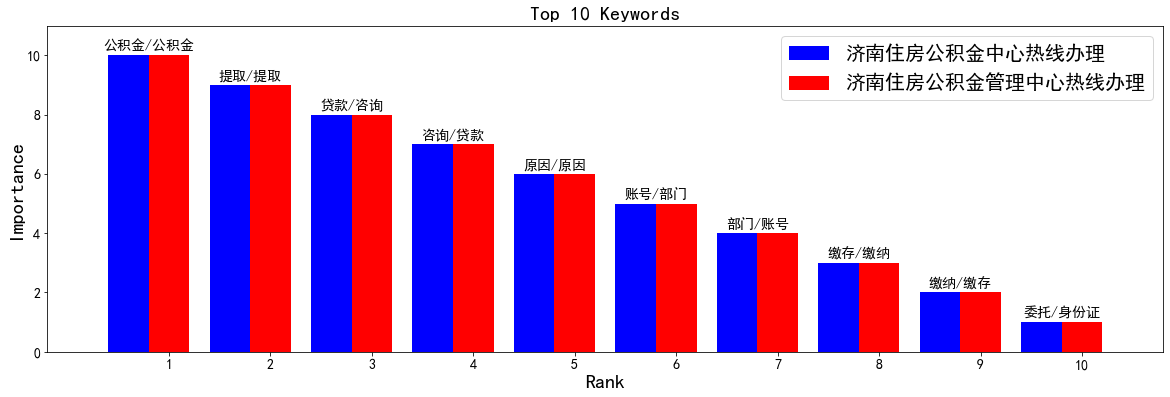

The co-occurrence score = 0.900000


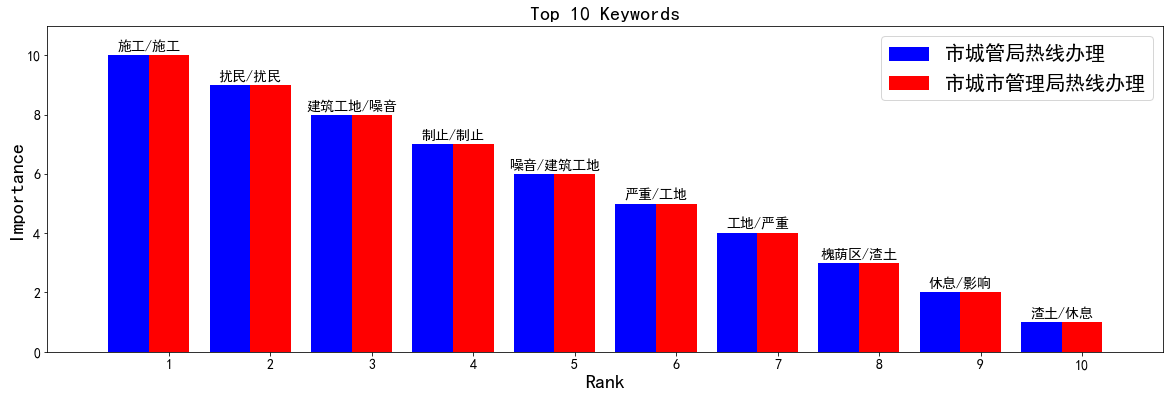

The co-occurrence score = 0.800000


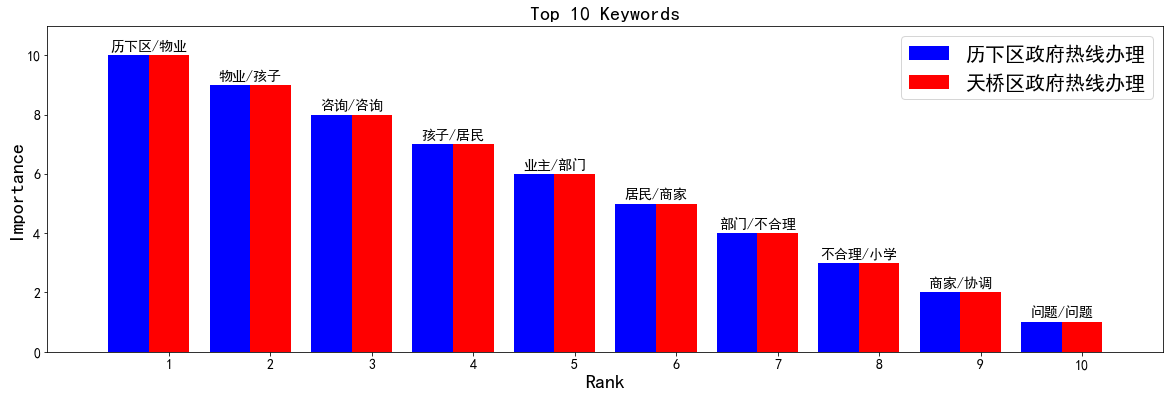

The co-occurrence score = 0.800000


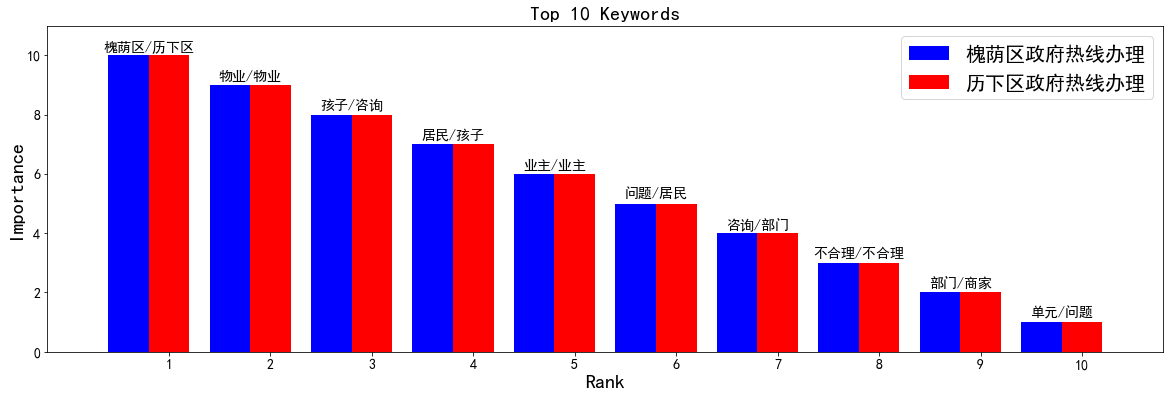

The co-occurrence score = 0.800000


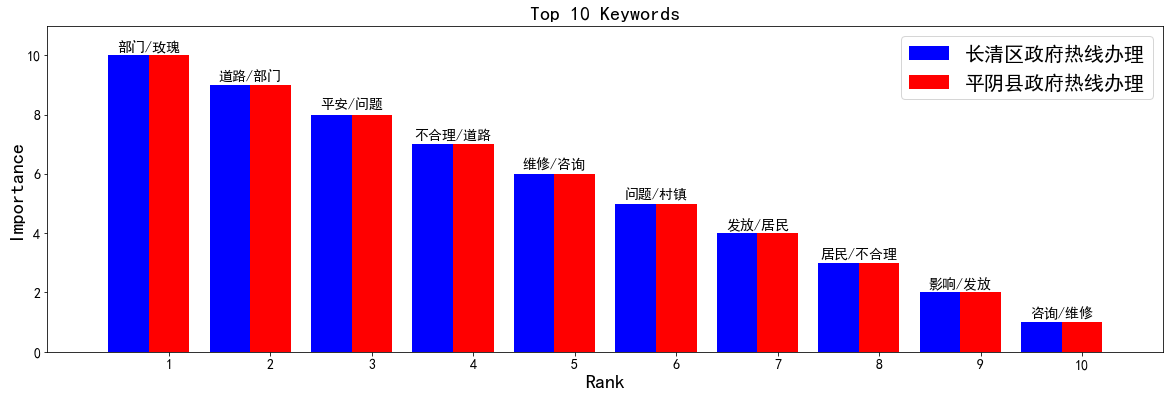

In [7]:
!pip install chineseize-matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import chineseize_matplotlib

selected_k = 5 #展示相关性最高的多少对文档 及其关键词
selected_k2 = 20 #保存相关性最高的多少对文档（办理单位）及其关键词

def co_occurrence_score(i, j):
  '''
  计算两个关键词集合的相关度分数
  '''
  i = i.split()
  j = j.split()
  result = list(set(i).intersection(set(j)))
  score = len(result)/len(i)
  return score 

def co_occurrence_words(i, j):
  '''
  计算两个关键词集合的共同单词
  '''
  i = i.split()
  j = j.split()
  result = list(set(i).intersection(set(j)))
  return result

def Compute_Similarity_df():
  '''
  计算每两篇文档的相似度，并将其按照相似度排序，由高到低
  '''
  result = pd.read_csv("keys_TFIDF.csv")
  record = []
  for i, keyword_i in enumerate(result['key']):
    for j, keyword_j in enumerate(result['key']):
      if i==j:
        break
      record.append([result['title'][i], result['title'][j], co_occurrence_score(keyword_i, keyword_j), result['key'][i], result['key'][j], co_occurrence_words(keyword_i, keyword_j)])
    if i%10==0:     
      print('=========================')
      print('Processing %d/%d'%(i, len(result['key'])))
  record = pd.DataFrame(record)
  
  record.sort_values(by=2,ascending=False).iloc[:selected_k2, :].to_csv('Top_Similarity_Document.csv')
  record = record.sort_values(by=2,ascending=False).iloc[:selected_k, :]
  print('Co-occurrence Score:\n',record)
  #print('all_data占据内存约: {:.2f} GB'.format(record.memory_usage().sum()/ (1024**3)))
  return record

def plot_by_row(top_i):
  '''
  将前几行的数据进行可视化
  '''
  print('========================')
  print('The co-occurrence score = %f'%record[2].iloc[top_i])
  keywords_list_1 = record[3].iloc[top_i].split()
  keywords_list_2 = record[4].iloc[top_i].split()
  document_1 = record[0].iloc[top_i]
  document_2 = record[1].iloc[top_i]
  total_width, n = .8, 2  
  width = total_width / n
  x = list(range(1,11))
  x1 = [inst- .5* width for inst in x]
  x2 = [inst+ .5* width for inst in x]
  y = np.linspace(10, 1, 10)
  name = list(range(1,11,1))
  name = [str(inst) for inst in name]

  plt.figure(figsize=(20,6))
  plt.bar(x1, y, width= width, label= document_1, fc = 'b')
  plt.bar(x2, y, width= width, label= document_2, tick_label = name, fc = 'r') 
  plt.tick_params(axis='both',labelsize=14)
  plt.axis([0,11,0,11])
  for a,b in zip(x, y):
      plt.text(a,b+0.1,u'%s/%s'%(keywords_list_1[a-1],keywords_list_2[a-1]),ha = 'center', va = 'bottom', fontsize=14)
  # plt.savefig('images\squares.png')
  plt.title('Top %d Keywords'%10,fontsize=20)
  plt.xlabel('Rank',fontsize=20)
  plt.ylabel('Importance',fontsize=20)
  plt.legend(fontsize= 20)
  plt.show()

record = Compute_Similarity_df()
for top_i in range(selected_k):
  plot_by_row(top_i)
